In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data
    
    def secondOrder(self):
        for col in self.data:
            self.data[col+'(t-1)'] = self.data[col].shift(1)
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.secondOrder()
training_data = training.drop_nan()
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-04-18 23:21:42+00:00,69.5,69.5,66.499700,0.0,0,0,69.5,69.483333,66.499700,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,69.5,69.5,66.520546,0.0,0,0,69.5,69.500000,66.499700,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,69.4,69.5,66.583083,0.0,0,0,69.5,69.500000,66.520546,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,69.5,69.4,66.666466,0.0,0,0,69.4,69.500000,66.583083,0.0,0.0,0.0
2018-04-18 23:41:42+00:00,69.4,69.5,66.729007,0.0,0,0,69.5,69.400000,66.666466,0.0,0.0,0.0


In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.secondOrder()
testing_data = testing.drop_nan()
testing_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-03-20 00:05:00+00:00,73.0,72.8,67.807436,0.0,0,0,72.8,72.8,67.778613,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,73.0,73.0,67.835998,0.0,0,0,73.0,72.8,67.807436,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,73.0,73.0,67.864038,0.0,0,0,73.0,73.0,67.835998,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,73.0,73.0,67.891817,0.0,0,0,73.0,73.0,67.864038,0.0,0.0,0.0
2018-03-20 00:25:00+00:00,73.0,73.0,67.865168,0.0,0,0,73.0,73.0,67.891817,0.0,0.0,0.0


In [5]:
train_y = training_data['t_next']
train_X = training_data.drop(['t_next', 't_next(t-1)'], axis=1)
train_X.head()

,t_in,t_out,occ,action_heating,action_cooling,t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,
2018-04-18 23:21:42+00:00,69.5,66.499700,0.0,0,0,69.483333,66.499700,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,69.5,66.520546,0.0,0,0,69.500000,66.499700,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,69.5,66.583083,0.0,0,0,69.500000,66.520546,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,69.4,66.666466,0.0,0,0,69.500000,66.583083,0.0,0.0,0.0
2018-04-18 23:41:42+00:00,69.5,66.729007,0.0,0,0,69.400000,66.666466,0.0,0.0,0.0


In [6]:
test_y = testing_data['t_next']
test_X = testing_data.drop(['t_next', 't_next(t-1)'], axis=1)
test_X.head()

,t_in,t_out,occ,action_heating,action_cooling,t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0,72.8,67.778613,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0,72.8,67.807436,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0,73.0,67.835998,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0,73.0,67.864038,0.0,0.0,0.0
2018-03-20 00:25:00+00:00,73.0,67.865168,0.0,0,0,73.0,67.891817,0.0,0.0,0.0


In [9]:
from sklearn.linear_model import Ridge

ridge_clf = Ridge(alpha=1.0)
ridge_clf.fit(train_X, train_y)
test_pred = ridge_clf.predict(test_X)

In [10]:
rmse = sqrt(mean_squared_error(test_y,test_pred))
rmse

0.8666426782247197

In [11]:
def forecasting(test_X, test_y, start_time, duration, linearModel):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in test_X.index:
            #print("Not present")
            return None
        input_x = test_X.loc[curr_time].copy()
        if len(predictions_i) < 2:
            predictions_i.append(input_x['t_in'])
        else:
            input_x['t_in'] = predictions_i[-1]
            input_x['t_in(t-1)'] = predictions_i[-2]
        y = linearModel.predict([input_x])
        predictions_i.append(y[0])
        errs_i.append(test_y.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [12]:
predictions = []
errs = []
startSamples = test_X.sample(n=800)
startList = startSamples.index
duration = 60 * 7
for start in startList:
    errs_i = forecasting(test_X, test_y, start, duration, ridge_clf)
    #predictions.append(pd.Series(index=range(len(predictions_i)), data=predictions_i))
    if errs_i:
        errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
#print(predictions)
#print(errs)

[0.11873982988852697, 0.19117270516231566, 0.279978299199716, 0.34361845100927074, 0.41308832930619954, 0.46500717046633905, 0.5184837539761825, 0.5673778211459346, 0.6037508158432161, 0.6477300300545772, 0.6874990916297844, 0.715112283210379, 0.7734523119183643, 0.8266302845969985, 0.8611812513565781, 0.8945270987293957, 0.9302007893841671, 0.9689375876943633, 1.0002730882568416, 1.0542924290160776, 1.0998335857180415, 1.1229921052718697, 1.1420113442586866, 1.1779216733946267, 1.2142317768455897, 1.2401014809240185, 1.2747756172461135, 1.3113644618540556, 1.3445976732299476, 1.3769270826276652, 1.4176867572858476, 1.4558054436646317, 1.4865584911823209, 1.5310001304983745, 1.5795257265950071, 1.622950022484567, 1.6491984778021738, 1.6768656854564992, 1.707056504351224, 1.7462754510860774, 1.7754047955754042, 1.8123636138006827, 1.8417184341799515, 1.848503977101227, 1.8504186842620807, 1.8580762465310239, 1.8683523945300302, 1.887142840004864, 1.8987388002055516, 1.925551395067957, 1

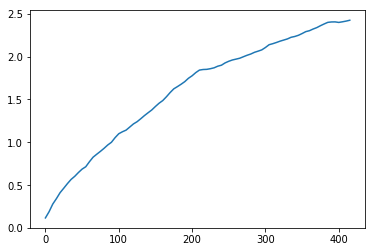

In [13]:
final_errors = []
for i in range(int(duration/5)):
    ei = np.array([])
    for e in errs:
        ei = np.append(ei, e.loc[i]*e.loc[i])
    final_errors.append(sqrt(np.mean(ei)))
#final_errors = pd.Series(index=range(len(final_errors)), data = final_errors)
print(final_errors)
timesteps = [x*5 for x in range(len(final_errors))]
plt.plot(timesteps,final_errors)
plt.show()